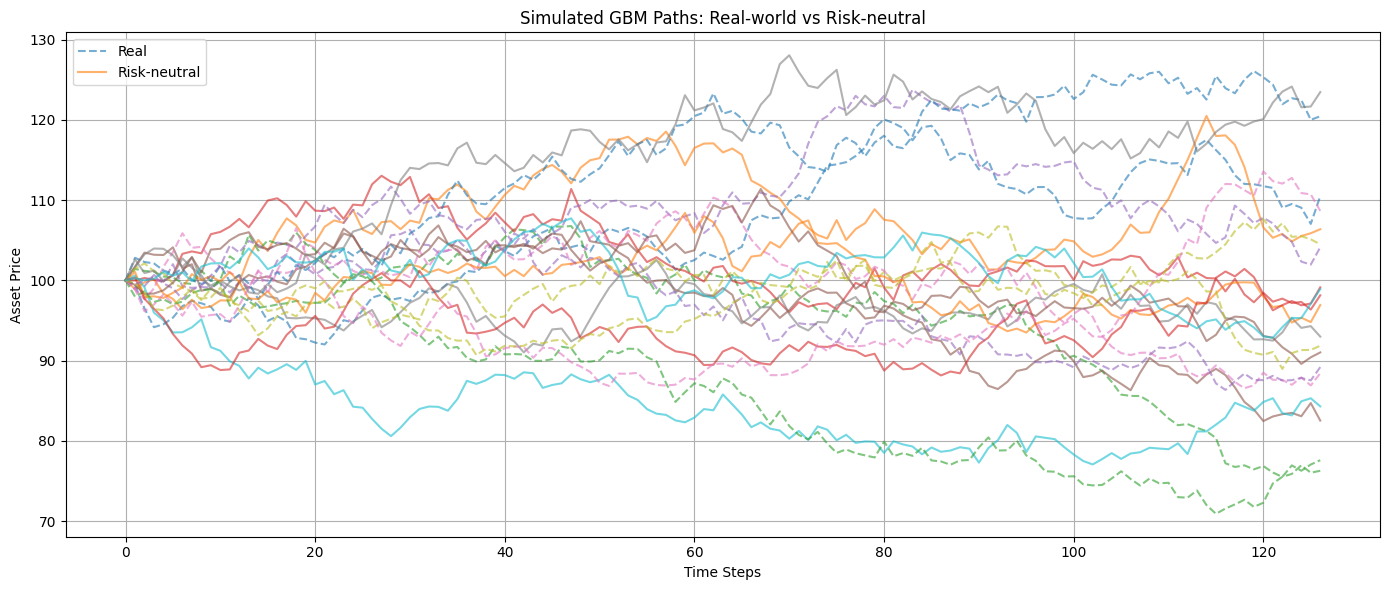

ModuleNotFoundError: No module named 'ace_tools'

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100
mu = 0.10
sigma = 0.20
r = 0.05
T = 0.5
K_values = [90, 105, 110]
n_paths = 10
n_steps = 126  # roughly 252/2
dt = T / n_steps

# Function to simulate GBM paths
def simulate_gbm(S0, mu, sigma, T, n_steps, n_paths):
    dt = T / n_steps
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    for t in range(1, n_steps + 1):
        Z = np.random.standard_normal(n_paths)
        S[:, t] = S[:, t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return S

# Simulate real-world and risk-neutral paths
real_world_paths = simulate_gbm(S0, mu, sigma, T, n_steps, n_paths)
risk_neutral_paths = simulate_gbm(S0, r, sigma, T, n_steps, n_paths)

# Function to compute Asian option prices using Monte Carlo
def asian_option_price(paths, K, r, T, option_type='call'):
    avg_prices = np.mean(paths[:, 1:], axis=1)
    if option_type == 'call':
        payoffs = np.maximum(avg_prices - K, 0)
    else:
        payoffs = np.maximum(K - avg_prices, 0)
    return np.exp(-r * T) * np.mean(payoffs)

# Compute Asian option prices for different strikes
results = []
for K in K_values:
    call_price = asian_option_price(risk_neutral_paths, K, r, T, option_type='call')
    put_price = asian_option_price(risk_neutral_paths, K, r, T, option_type='put')
    results.append((K, call_price, put_price))

# Plot the simulated paths
plt.figure(figsize=(14, 6))
for i in range(n_paths):
    plt.plot(real_world_paths[i], linestyle='--', alpha=0.6, label='Real' if i == 0 else "")
    plt.plot(risk_neutral_paths[i], alpha=0.6, label='Risk-neutral' if i == 0 else "")
plt.title('Simulated GBM Paths: Real-world vs Risk-neutral')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import pandas as pd
df = pd.DataFrame(results, columns=['Strike Price (K)', 'Call Price', 'Put Price'])
import ace_tools as tools; tools.display_dataframe_to_user(name="Asian Option Prices", dataframe=df)

In [ ]:
# Sensitivity Analysis over sigma, r, and T
sigma_values = [0.15, 0.20, 0.25]
r_values = [0.03, 0.05, 0.07]
T_values = [0.25, 0.5, 1.0]
K = 105  # fixed strike for sensitivity

sensitivity_results = []

for sigma_val in sigma_values:
    for r_val in r_values:
        for T_val in T_values:
            n_steps = int(252 * T_val)
            paths = simulate_gbm(S0, r_val, sigma_val, T_val, n_steps, 1000)  # More paths for stability
            call_price = asian_option_price(paths, K, r_val, T_val, option_type='call')
            put_price = asian_option_price(paths, K, r_val, T_val, option_type='put')
            sensitivity_results.append((sigma_val, r_val, T_val, call_price, put_price))

df_sensitivity = pd.DataFrame(
    sensitivity_results,
    columns=["Volatility (sigma)", "Risk-free Rate (r)", "Maturity (T)", "Call Price", "Put Price"]
)

tools.display_dataframe_to_user(name="Asian Option Sensitivity Analysis", dataframe=df_sensitivity)

In [ ]:
# Parameters for variance reduction
K = 105
n_paths = 10000
n_steps = 126
dt = T / n_steps

# Closed-form solution for geometric Asian option
def geometric_asian_option_price(S0, K, r, sigma, T, option_type='call'):
    sigma_hat = sigma / np.sqrt(3)
    mu_hat = 0.5 * (r - 0.5 * sigma ** 2) + 0.5 * sigma_hat ** 2
    d1 = (np.log(S0 / K) + (mu_hat + 0.5 * sigma_hat ** 2) * T) / (sigma_hat * np.sqrt(T))
    d2 = d1 - sigma_hat * np.sqrt(T)

    from scipy.stats import norm
    if option_type == 'call':
        price = np.exp(-r * T) * (S0 * np.exp(mu_hat * T) * norm.cdf(d1) - K * norm.cdf(d2))
    else:
        price = np.exp(-r * T) * (K * norm.cdf(-d2) - S0 * np.exp(mu_hat * T) * norm.cdf(-d1))
    return price

# Antithetic Variates Simulation
def asian_price_antithetic(S0, K, r, sigma, T, n_steps, n_paths, option_type='call'):
    dt = T / n_steps
    S_paths = np.zeros((2 * n_paths, n_steps + 1))
    S_paths[:, 0] = S0

    for t in range(1, n_steps + 1):
        Z = np.random.randn(n_paths)
        Z_antithetic = -Z
        for i, Z_i in enumerate([Z, Z_antithetic]):
            S_paths[i * n_paths:(i + 1) * n_paths, t] = (
                S_paths[i * n_paths:(i + 1) * n_paths, t - 1] *
                np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z_i)
            )
    averages = np.mean(S_paths[:, 1:], axis=1)
    if option_type == 'call':
        payoffs = np.maximum(averages - K, 0)
    else:
        payoffs = np.maximum(K - averages, 0)
    return np.exp(-r * T) * np.mean(payoffs)

# Control Variate Method
def asian_price_control_variate(S0, K, r, sigma, T, n_steps, n_paths, option_type='call'):
    dt = T / n_steps
    arith_payoffs = []
    geo_payoffs = []

    for _ in range(n_paths):
        Z = np.random.randn(n_steps)
        path = np.zeros(n_steps + 1)
        path[0] = S0
        for t in range(1, n_steps + 1):
            path[t] = path[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[t - 1])
        arith_avg = np.mean(path[1:])
        geo_avg = np.exp(np.mean(np.log(path[1:])))

        if option_type == 'call':
            arith_payoff = np.maximum(arith_avg - K, 0)
            geo_payoff = np.maximum(geo_avg - K, 0)
        else:
            arith_payoff = np.maximum(K - arith_avg, 0)
            geo_payoff = np.maximum(K - geo_avg, 0)

        arith_payoffs.append(arith_payoff)
        geo_payoffs.append(geo_payoff)

    arith_payoffs = np.array(arith_payoffs)
    geo_payoffs = np.array(geo_payoffs)

    cov_xy = np.cov(arith_payoffs, geo_payoffs)[0, 1]
    var_y = np.var(geo_payoffs)
    c = -cov_xy / var_y

    geo_price_exact = geometric_asian_option_price(S0, K, r, sigma, T, option_type)
    price_cv = np.exp(-r * T) * np.mean(arith_payoffs + c * (geo_payoffs - geo_price_exact))
    return price_cv

# Compute prices using variance reduction
call_antithetic = asian_price_antithetic(S0, K, r, sigma, T, n_steps, n_paths, option_type='call')
put_antithetic = asian_price_antithetic(S0, K, r, sigma, T, n_steps, n_paths, option_type='put')

call_control = asian_price_control_variate(S0, K, r, sigma, T, n_steps, n_paths, option_type='call')
put_control = asian_price_control_variate(S0, K, r, sigma, T, n_steps, n_paths, option_type='put')

# Display results
vr_df = pd.DataFrame({
    "Technique": ["Antithetic", "Antithetic", "Control Variate", "Control Variate"],
    "Option Type": ["Call", "Put", "Call", "Put"],
    "Estimated Price": [call_antithetic, put_antithetic, call_control, put_control]
})

tools.display_dataframe_to_user(name="Variance Reduction Option Prices", dataframe=vr_df)